In [2]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [3]:
dtype = torch.float
device = torch.device("cpu")
torch.manual_seed(1)


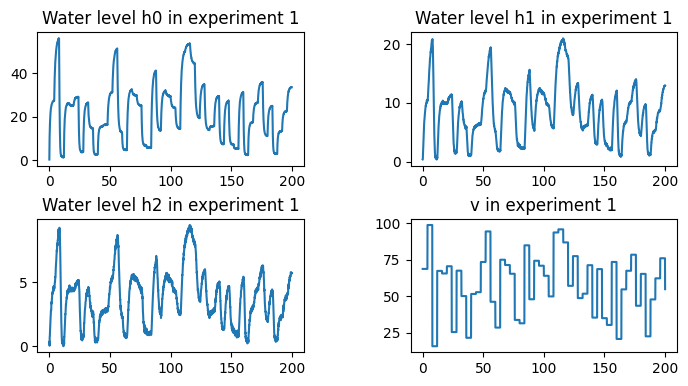

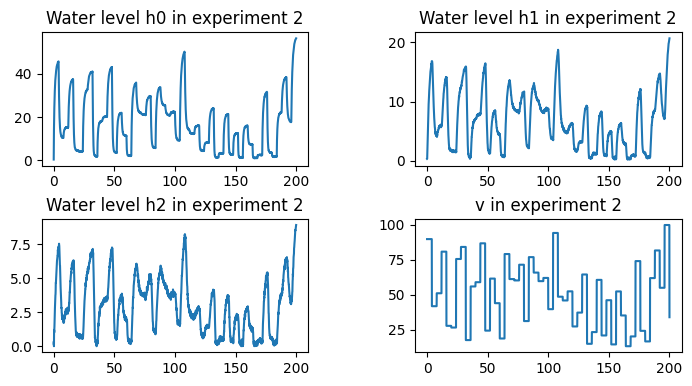

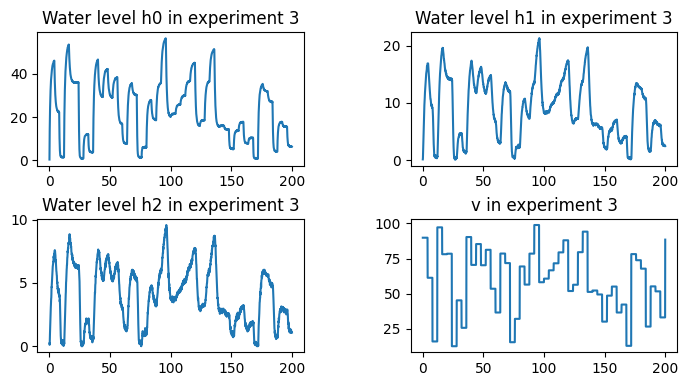

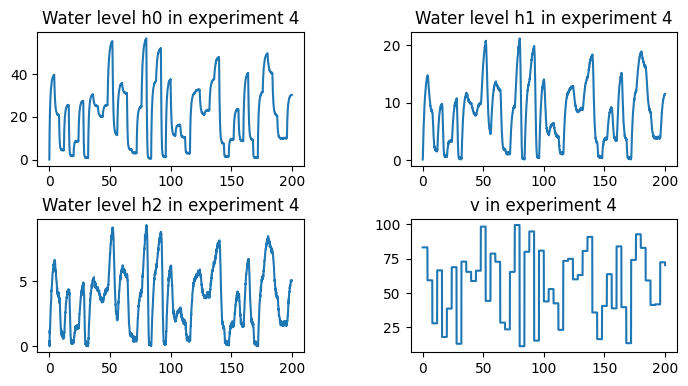

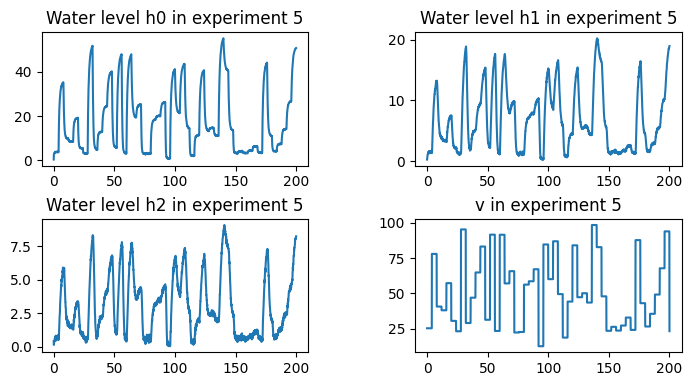

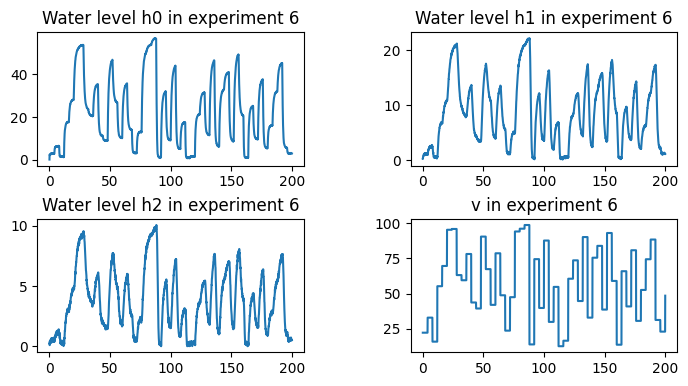

In [4]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'dataset_sysID_3tanks.mat')
data = scipy.io.loadmat(filepath)

dExp, yExp, dExp_val, yExp_val, Ts = data['dExp'], data['yExp'], \
    data['dExp_val'], data['yExp_val'], data['Ts'].item()
nExp = yExp.size

ny = np.shape(yExp[0,-1])[0]
nd = np.shape(dExp[0,-1])[0]

washout = 10 # washout datapoints in the loss

t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
t_end = yExp[0, 0].shape[1] - 1
t_end_val = yExp_val[0, 0].shape[1] 


for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t, y_exp[out,:])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t, d_exp[1,:])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

Epoch: 1 	||	 Loss: 255.90072631835938
Epoch: 2 	||	 Loss: 251.32618713378906
Epoch: 3 	||	 Loss: 249.57044982910156
Epoch: 4 	||	 Loss: 247.24061584472656
Epoch: 5 	||	 Loss: 243.1046600341797
Epoch: 6 	||	 Loss: 234.26405334472656
Epoch: 7 	||	 Loss: 215.13003540039062
Epoch: 8 	||	 Loss: 175.37660217285156
Epoch: 9 	||	 Loss: 140.26426696777344
Epoch: 10 	||	 Loss: 142.55226135253906
Epoch: 11 	||	 Loss: 101.52047729492188
Epoch: 12 	||	 Loss: 99.2409439086914
Epoch: 13 	||	 Loss: 85.92001342773438
Epoch: 14 	||	 Loss: 57.22382736206055
Epoch: 15 	||	 Loss: 38.08708572387695
Epoch: 16 	||	 Loss: 53.831016540527344
Epoch: 17 	||	 Loss: 22.983800888061523
Epoch: 18 	||	 Loss: 25.86137580871582
Epoch: 19 	||	 Loss: 32.019283294677734
Epoch: 20 	||	 Loss: 26.69484519958496
Epoch: 21 	||	 Loss: 17.72521209716797
Epoch: 22 	||	 Loss: 23.494735717773438
Epoch: 23 	||	 Loss: 28.736278533935547
Epoch: 24 	||	 Loss: 20.059131622314453
Epoch: 25 	||	 Loss: 22.433673858642578
Epoch: 26 	||	 Los

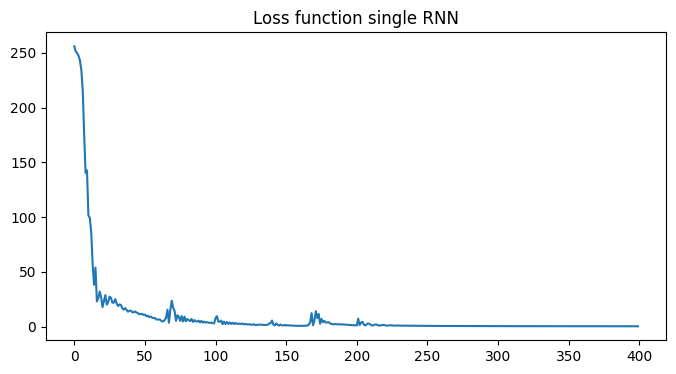

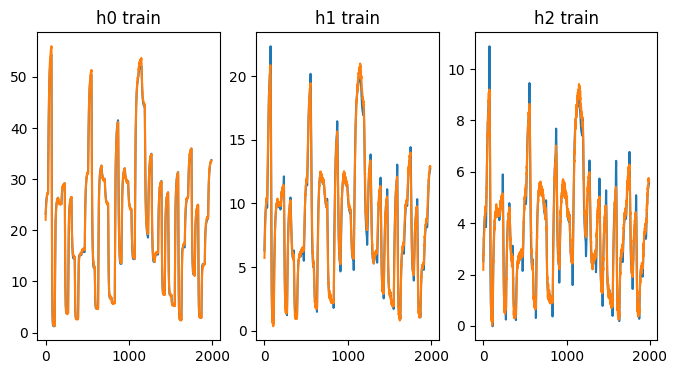

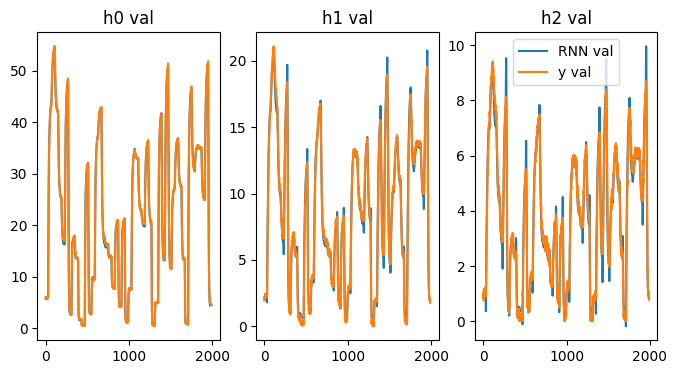

Loss Validation single RNN: 0.3090214729309082


In [5]:
# Train single RNN
epochs = 400
n = 1  # input dimensions
inputnumberD = 1
p = ny  # output dimensions

u = torch.zeros(nExp, t_end+1, n)
y = torch.zeros(nExp, t_end+1, p)

for j in range(nExp):
    inputActive = (torch.from_numpy(dExp[0, j])).T
    u[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    y[j, :, :] = (torch.from_numpy(yExp[0, j])).T


idd = 1
hdd = 18
ldd = 5
odd = yExp[0, 0].shape[0]

RNN = RNNModel(idd, hdd, ldd, odd)
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    lossRNN = 0

    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    lossRNN = MSE(yRNN[:,washout:,:], y[:,washout:,:])
    lossRNN.backward()
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {lossRNN}")
    LOSS[epoch] = lossRNN

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single RNN")
plt.show()


nExp_val = yExp_val.size

uval = torch.zeros(nExp_val, t_end_val, 1)
yval = torch.zeros(nExp_val, t_end_val, 3)

for j in range(nExp_val):
    inputActive = (torch.from_numpy(dExp_val[0, j])).T
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j])).T

yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)

loss_val_RNN = MSE(yRNN_val[washout:,:], torch.squeeze(yval)[washout:,:])

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRNN[0,washout:t_end,out].detach().numpy(), label='RNN train')
    plt.plot(y[0, washout:t_end,out].detach().numpy(), label='y train')
    plt.title(r"h%i"%out + r" train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRNN_val[washout:t_end,out].detach().numpy(), label='RNN val')
    plt.plot(yval[0, washout:t_end,out].detach().numpy(), label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

pytorch_total_params_singleRNN = sum(p.numel() for p in RNN.parameters() if p.requires_grad)
print(f"Loss Validation single RNN: {loss_val_RNN}")

torch.save({
    'model_state_dict': RNN.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': LOSS,
    'model_config': {
        'idd': idd,
        'hdd': hdd,
        'ldd': ldd,
        'odd': odd,
    },
    'epoch': epochs,
}, 'saved_models/RNN_checkpoint.pt')

Epoch: 1 	||	 Loss: 137.95204162597656
L2 gain REN: 0.1600000113248825
Epoch: 2 	||	 Loss: 92.97197723388672
L2 gain REN: 0.25012722611427307
Epoch: 3 	||	 Loss: 50.4627685546875
L2 gain REN: 0.35966014862060547
Epoch: 4 	||	 Loss: 26.092498779296875
L2 gain REN: 0.47944405674934387
Epoch: 5 	||	 Loss: 24.761438369750977
L2 gain REN: 0.574482798576355
Epoch: 6 	||	 Loss: 36.01457595825195
L2 gain REN: 0.6112402081489563
Epoch: 7 	||	 Loss: 38.107730865478516
L2 gain REN: 0.6034160852432251
Epoch: 8 	||	 Loss: 28.008047103881836
L2 gain REN: 0.5769867897033691
Epoch: 9 	||	 Loss: 17.760726928710938
L2 gain REN: 0.5532636642456055
Epoch: 10 	||	 Loss: 17.354171752929688
L2 gain REN: 0.5390071868896484
Epoch: 11 	||	 Loss: 19.025259017944336
L2 gain REN: 0.5358445048332214
Epoch: 12 	||	 Loss: 17.951871871948242
L2 gain REN: 0.5399327874183655
Epoch: 13 	||	 Loss: 15.2462797164917
L2 gain REN: 0.549122154712677
Epoch: 14 	||	 Loss: 13.699272155761719
L2 gain REN: 0.5591752529144287
Epoch:

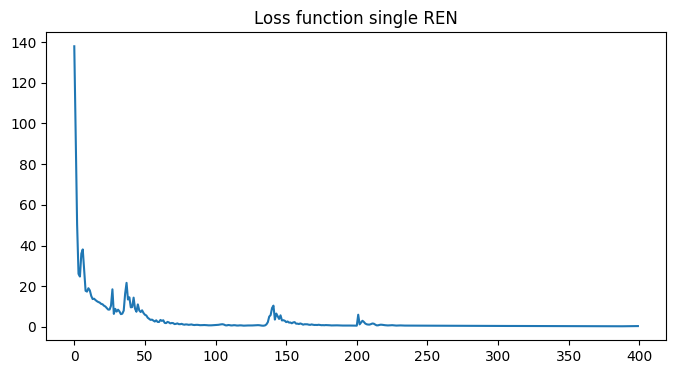

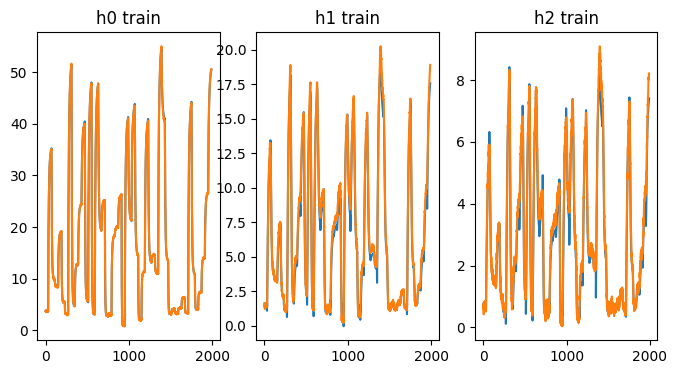

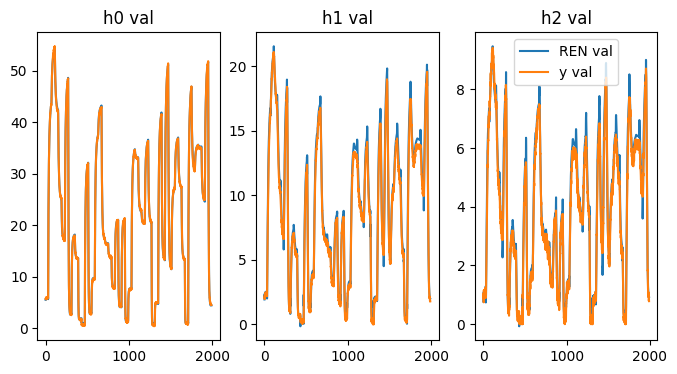

Loss Validation single REN: 0.1754385530948639


In [6]:
# Train single REN
epochs = 400

n = 1  # input dimensions
inputnumberD = 1
p = ny  # output dimensions

n_xi = 18# nel paper n1, numero di stati
l = 18  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = True)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze()
        yRENm = torch.randn(p, t_end + 1, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.from_numpy(dExp[0, exp]).float().to(device)
        for t in range(1, t_end):
            u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(u, xi, t)
        loss = loss + MSE(yRENm[:, washout:yRENm.size(1)], y[:, washout:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()

yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()

yRENm_val = torch.zeros(p, t_end_val, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
loss_val = 0
for t in range(1, t_end_val):
    u = torch.tensor([dval[inputnumberD, t]])
    yRENm_val[:, t], xiVal = RENsys(u, xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, washout:yRENm_val.size(1)], yval[:, washout:t_end_val])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm[out, washout:t_end].detach().numpy(), label='REN train')
    plt.plot(y[out, washout:t_end].detach().numpy(), label='y train')
    plt.title(r"h%i"%out + r" train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, washout:t_end].detach().numpy(), label='REN val')
    plt.plot(yval[out, washout:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN: {loss_val_REN}")

# Save complete checkpoint
torch.save({
    'model_state_dict': RENsys.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': LOSS,
    'model_config': {
        'n': n,
        'p': p,
        'n_xi': n_xi,
        'l': l,
        'gammaTrain': True,
    },
    'epoch': epochs,
    'gamma': RENsys.gamma.detach().cpu().numpy() if hasattr(RENsys, 'gamma') else None,
}, 'saved_models/single_REN_checkpoint.pt')

Epoch: 1 	||	 Loss: 218.85015869140625
L2 gain REN0:0.4
L2 gain REN1:0.6
L2 gain REN2:0.8
Epoch: 2 	||	 Loss: 138.96441650390625
L2 gain REN0:0.4
L2 gain REN1:0.5
L2 gain REN2:0.7
Epoch: 3 	||	 Loss: 72.77228546142578
L2 gain REN0:0.4
L2 gain REN1:0.6
L2 gain REN2:0.8
Epoch: 4 	||	 Loss: 36.25384521484375
L2 gain REN0:0.4
L2 gain REN1:0.6
L2 gain REN2:0.9
Epoch: 5 	||	 Loss: 39.20478439331055
L2 gain REN0:0.5
L2 gain REN1:0.6
L2 gain REN2:0.9
Epoch: 6 	||	 Loss: 44.66855239868164
L2 gain REN0:0.5
L2 gain REN1:0.6
L2 gain REN2:0.9
Epoch: 7 	||	 Loss: 41.54265213012695
L2 gain REN0:0.4
L2 gain REN1:0.6
L2 gain REN2:0.9
Epoch: 8 	||	 Loss: 33.126285552978516
L2 gain REN0:0.4
L2 gain REN1:0.5
L2 gain REN2:0.8
Epoch: 9 	||	 Loss: 25.105758666992188
L2 gain REN0:0.4
L2 gain REN1:0.5
L2 gain REN2:0.7
Epoch: 10 	||	 Loss: 20.630115509033203
L2 gain REN0:0.4
L2 gain REN1:0.4
L2 gain REN2:0.6
Epoch: 11 	||	 Loss: 19.94040870666504
L2 gain REN0:0.3
L2 gain REN1:0.4
L2 gain REN2:0.6
Epoch: 12 	||	

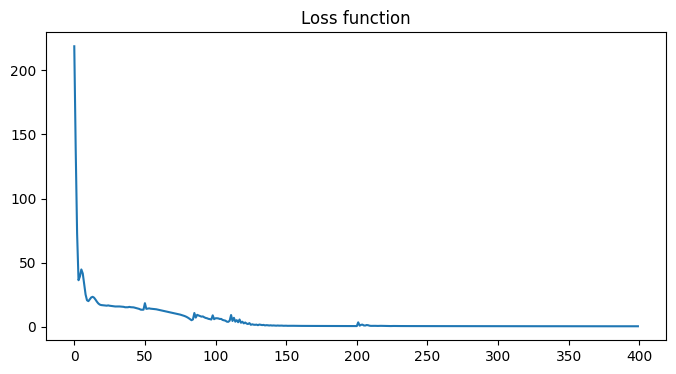

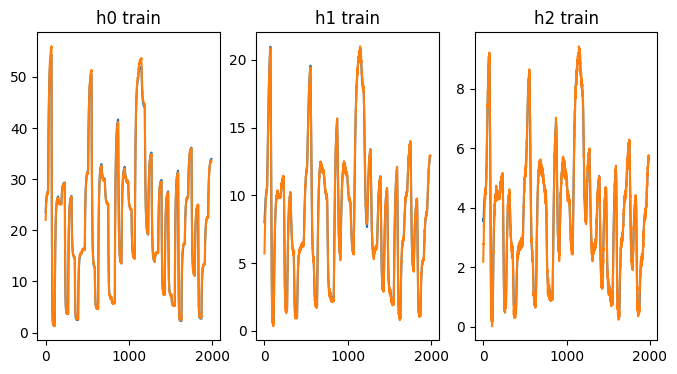

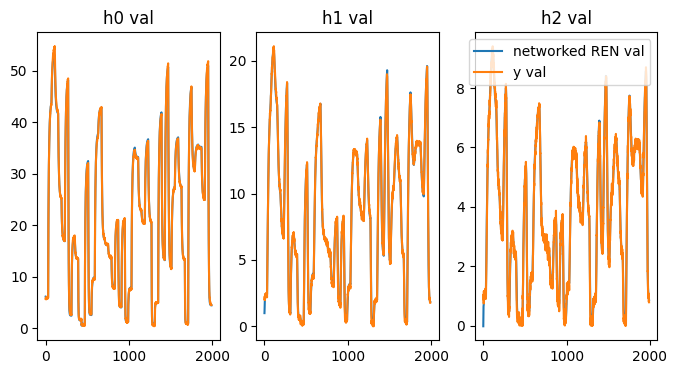

number of parameters single RNN: 3171
number of parameters single REN: 3353
number of parameters networked RENs: 3157
Loss Validation single RNN: 0.3090214729309082
Loss Validation single REN: 0.1754385530948639
Loss Validation networked RENs: 0.11911951750516891


In [34]:
# TRAIN OF NETWORKED RENs
epochs = 400

N = 3 # Number of interconnected systems

n = torch.tensor([2, 1, 1])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 10, 10]) # nel paper n1, numero di stati
l = np.array([10, 10, 10])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

Muy = torch.tensor([[0, 0, 1], [0, 0, 0], [1, 0, 0], [0, 1, 0]])
Muy = Muy.float()

Mud = torch.eye(n.sum())
Mey = torch.eye(p.sum())

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        xi = []
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze()
        yRENm = torch.randn(3, t_end + 1, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.from_numpy(dExp[0, exp]).float().to(device)
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, washout:yRENm.size(1)], y[:, washout:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    loss.backward()
    # loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function")
plt.show()

# Validation
xi = []
y = torch.from_numpy(yExp[0, 0]).float().to(device)
y = y.squeeze()
yRENm = torch.zeros(3, t_end + 1, device=device, dtype=dtype)
yRENm[:,0] = y[:,0]
for j in range(N):
    xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dtrain = torch.from_numpy(dExp[0, 0]).float().to(device)
xi = torch.cat(xi)
for t in range(1, t_end):
    yRENm[:, t], xi = RENsys(t, dtrain[:, t - 1], xi)


xiVal =[]
yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()
yRENm_val = torch.zeros(3, t_end_val, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
for j in range(N):
    xiVal.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
xiVal = torch.cat(xiVal)
loss_val = 0
for t in range(1, t_end_val):
    yRENm_val[:, t], xiVal = RENsys(t, dval[:, t - 1], xiVal)
loss_val = loss_val + MSE(yRENm_val[:, washout:yRENm_val.size(1)], yval[:, washout:t_end_val])

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm[out, washout:t_end].detach().numpy(), label='networked REN train')
    plt.plot(y[out, washout:t_end].detach().numpy(), label='y train')
    plt.title(r"h%i"%out + r" train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, washout:t_end].detach().numpy(), label='networked REN val')
    plt.plot(yval[out, washout:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

pytorch_total_params_3RENs = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)



print(f"number of parameters single RNN: {pytorch_total_params_singleRNN}")
print(f"number of parameters single REN: {pytorch_total_params_singleREN}")
print(f"number of parameters networked RENs: {pytorch_total_params_3RENs}")

print(f"Loss Validation single RNN: {loss_val_RNN}")
print(f"Loss Validation single REN: {loss_val_REN}")
print(f"Loss Validation networked RENs: {loss_val}")

# Save complete checkpoint for Networked RENs
torch.save({
    'model_state_dict': RENsys.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': LOSS,
    'model_config': {
        'N': N,
        'Muy': Muy.cpu(),  # save as tensor
        'Mud': Mud.cpu(),
        'Mey': Mey.cpu(),
        'n': n.cpu(),
        'p': p.cpu(),
        'n_xi': n_xi.tolist(),
        'l': l.tolist(),
    },
    'epoch': epochs,
    'gammas': [RENsys.r[j].gamma.item() for j in range(N)],
}, 'saved_models/networked_RENs_checkpoint.pt')